# 1. introduction

In this notebook we'll explore the Transformer architecture, a neural network that takes advantage of parallel processing and allows you to substantially speed up the training process. 

**After this Project you'll be able to**:
* Understand each step of Transformer Network
* understand Attention
* how to change paper to code 

### What is Transformer Model? 
The Transformer model, introduced in Attention Is All You Need (2017), is a deep learning architecture that replaces recurrence with self-attention to process sequences in parallel.
* the paper link [attention is all you need](https://arxiv.org/abs/1706.03762)

<img src="images/Transformer.png" alt="Encoder" width="600"/>
<caption><center><font color='Green'><b>Figure 1:  The Transformer- model architecture.</font></center></caption>


# 2. import Dependencies

In [1]:
# standard
import numpy as np
import matplotlib.pyplot as plt

# Tensorflow
import tensorflow as tf
from tensorflow.keras.layers import Embedding, MultiHeadAttention, Dense, Input, Dropout, LayerNormalization

# 3. Token Embedding

This layer converts token indices into dense vectors, similar to how PyTorch/TensorFlow embedding layers work.

<a name='6'></a>
### 3.1 - He Initialization

"He Initialization"; this is named for the first author of He et al., 2015. 


Implement the following function to initialize our parameters with He initialization.  $\sqrt{\frac{2}{\text{dimension of the previous layer}}}$, which is what He initialization recommends for layers with a ReLU activation. 

In [5]:
class TokenEmbedding:
    def __init__(self, VOCAB_SIZE, d_model):

        # VOCAB_SIZE: total number of unique tokens which means total vocabulary 
        # d_model: dimension  of each token's embedding vector 
        
        # initialize imbedding matrix with xavier method 
        self.VOCAB_SIEZ = VOCAB_SIZE
        self.d_model = d_model

        self.embedding_matrix = np.random.randn(VOCAB_SIZE, d_model) * np.sqrt(2/d_model)

    def toDenseVector(self, TOKEN_INDICES):
        # this change the token to its represented embedding matrix
        return self.embedding_matrix[TOKEN_INDICES]

### TEXT CASE

In [6]:
VOCAB_SIZE = 10000
d_model = 128
token_embedding = TokenEmbedding(VOCAB_SIZE, d_model)

token_indices = np.array([
    [1, 5, 7, 2, 8],  # First sequence
    [4, 3, 9, 6, 0]   # Second sequence
])

embedded_tokens = token_embedding.toDenseVector(token_indices)
print("Token Embeddings Shape:", embedded_tokens.shape)  # Expected: (2, 5, 128) 

""" 
2 => Batch size (in this case 2 sentence at once)
5 => Sequence Length ( 5 word on each sentence )
128 => embedding dense 
"""

Token Embeddings Shape: (2, 5, 128)


' \n2 => Batch size (in this case 2 sentence at once)\n5 => Sequence Length ( 5 word on each sentence )\n128 => embedding dense \n'

# 4. Positional Encoding

In sequence to sequence tasks, the relative order of our data is extremely important to its meaning. When we were training sequential neural networks such as RNNs, we fed our inputs into the network in order. Information about the order of our data was automatically fed into our model.  However, when we train a Transformer network using multi-head attention, we feed our data into the model all at once. While this dramatically reduces training time, there is no information about the order of our data. This is where positional encoding is useful - we can specifically encode the positions of our inputs and pass them into the network using these sine and cosine formulas:
$$
PE_{(pos, 2i)}= sin\left(\frac{pos}{{10000}^{\frac{2i}{d}}}\right)
\tag{1}$$

* $d$ is the dimension of the word embedding and positional encoding
* $pos$ is the position of the word.
* $k$ refers to each of the different dimensions in the positional encodings, with $i$ equal to $k$ $//$ $2$.
  
This ensures each position has a unique encoding and helps the model differentiate between words based on their order.

In [60]:
def get_angle(pos, k, d_model):
    """ 
    Computes angle values for the positional encoding
    pos is position of a specific token 
    k is embedding dimension 
    """
    i = k//2
    angles = (pos / np.power(10000, (2*i/d_model)))

    return angles

In [ ]:
def positional_encoding(positions, d_model):

    """
        Computes positional encoding matrix for a given sequence length and embedding dimension.

        positions: Maximum sequence length
        d_model: Embedding dimension

        return: Positional encoding matrix (1, positions, d_model)

        """
    
    # initialize the position_indices and dim_indices and and change int to 2D array then get angle for them 
    angle_rads = get_angle(np.arange(positions)[:, np.newaxis],
                           np.arange(d_model)[np.newaxis, :], d_model)
    
    # apply sine to even and cos to odd indices
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])


    # batch compatibility 
    batch_size = 2
    pos_encoding = np.tile(angle_rads[np.newaxis, ...], (batch_size, 1, 1)) 

    return tf.cast(pos_encoding, dtype=tf.float32)

In [68]:
POSITION = 20
d_model = 128

pos_enc = positional_encoding(POSITION, d_model)
print(pos_enc.shape)

(2, 20, 128)


TEST CASE

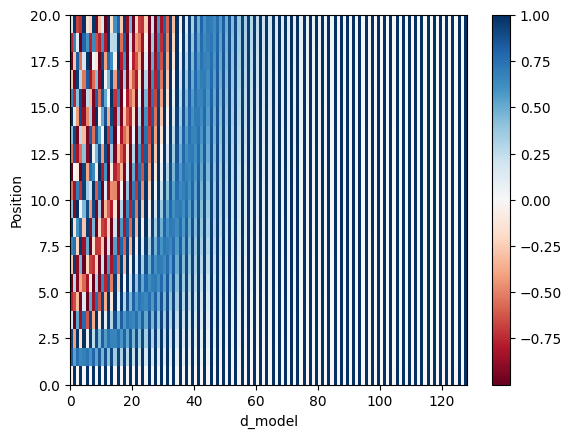

In [69]:
# visualize the positional encoding 
plt.pcolormesh(pos_enc[0], cmap='RdBu')
plt.xlabel('d_model')
plt.xlim((0, 128))
plt.ylabel('Position')
plt.colorbar()
plt.show()


Each row represents a positional encoding - notice how none of the rows are identical! we have created a unique positional encoding for each of the words.

# 5. Scaled Dot Product Attention
<img src="images/scaled_dot.png" alt="Encoder" width="300"/>
<caption><center><font color='Green'><b>Figure 2: The Transformer- model architecture.</font></center></caption>

We call our particular attention "Scaled Dot-Product Attention" The input consists of
queries and keys of dimension dk, and values of dimension dv. We compute the dot products of the
query with all keys, divide each by √dk, and apply a softmax function to obtain the weights on the values.

The use of self-attention paired with traditional convolutional networks allows for parallelization which speeds up training. You will implement **scaled dot product attention** which takes in a query, key, value, and a mask as inputs to return rich, attention-based vector representations of the words in your sequence. This type of self-attention can be mathematically expressed as:
$$
\text { Attention }(Q, K, V)=\operatorname{softmax}\left(\frac{Q K^{T}}{\sqrt{d_{k}}}+{M}\right) V\tag{4}\
$$

* $Q$ is the matrix of queries 
* $K$ is the matrix of keys
* $V$ is the matrix of values
* $M$ is the optional mask you choose to apply 
* ${d_k}$ is the dimension of the keys, which is used to scale everything down so the softmax doesn't explode

use this [tf.matmul](https://www.tensorflow.org/api_docs/python/tf/linalg/matmul) useful for matrix multiplication.


In [ ]:
def scaled_dot_product_attention(q, k, v, mask):
    # get the dk length
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    # scaled the dot product 

    scaled_attention_logits = matmul_qk / np.sqrt(dk)

    # calculate the softmax i.e weight attention 
    attention_weight = tf.nn.softmax(scaled_attention_logits, axis=-1) # tell us how much each word cares about others.

    output = tf.matmul(attention_weight, v)

    return output, attention_weight

TEST CASE

In [3]:

def test_scaled_dot_product_attention():
    # Define toy inputs (batch_size=2, num_heads=1, seq_length=3, depth=4)
    q = tf.constant([[[1.0, 0.0, 1.0, 0.0], 
                      [0.0, 1.0, 0.0, 1.0], 
                      [1.0, 1.0, 1.0, 1.0]]], dtype=tf.float32)  # (1, 3, 4)

    k = tf.constant([[[1.0, 0.0, 1.0, 0.0], 
                      [0.0, 1.0, 0.0, 1.0], 
                      [1.0, 1.0, 1.0, 1.0]]], dtype=tf.float32)  # (1, 3, 4)

    v = tf.constant([[[0.1, 0.2, 0.3, 0.4], 
                      [0.5, 0.6, 0.7, 0.8], 
                      [0.9, 1.0, 1.1, 1.2]]], dtype=tf.float32)  # (1, 3, 4)

    mask = None  # No mask for this test

    # Compute scaled dot-product attention
    output, attention_weights = scaled_dot_product_attention(q, k, v, mask)

    # Print results
    print("Attention Weights:\n", attention_weights.numpy())
    print("Output:\n", output.numpy())

# Run the test case
test_scaled_dot_product_attention()


Attention Weights:
 [[[0.42231882 0.15536243 0.42231882]
  [0.15536243 0.42231882 0.42231882]
  [0.21194157 0.21194157 0.57611686]]]
Output:
 [[[0.5        0.6        0.70000005 0.8000001 ]
  [0.60678256 0.7067826  0.8067826  0.9067826 ]
  [0.6456701  0.74567014 0.8456701  0.9456701 ]]]


# 6. Encoder
## 6.1 Multi-Head Attention

The Transformer Encoder layer pairs self-attention and convolutional neural network style of processing to improve the speed of training and passes K and V matrices to the Decoder. In this section of the Project we will implement the Encoder by pairing multi-head attention and a feed forward neural network 


<img src="images/encoder_layer.png" alt="Encoder" width="400"/>
<caption><center><font color='green'><b>Figure 3a: Transformer encoder layer</font></center></caption>

* `MultiHeadAttention`Multiple Heads: Instead of a single attention mechanism, the model uses several attention mechanisms (heads) in parallel.
Instead of performing a single attention function with dmodel-dimensional keys, values and queries,
 we found it beneficial to linearly project the queries, keys and values h times with different, learned
 linear projections to dk, dk and dv dimensions, respectively. On each of these projected versions of
 queries, keys and values we then perform the attention function in parallel, yielding dv-dimensional output values
  
<img src="images/multihead.png" alt="Multi-Head" width="400"/>
<caption><center><font color='green'><b>Figure 3b: Multi head Attention</font></center></caption>

* Feed forward neural network contains two Dense layers which we'll implement as the function `FullyConnected`





In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_head):
        super(MultiHeadAttention, self).__init__()
        self.num_head = num_head
        self.d_model = d_model

        assert d_model % num_head == 0
        self.depth = d_model//num_head

        # q,k,v linear layers prediction from keras

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model) #  MultiHead(Q,K,V ) = Concat(head1,...,headh)WO

    def split_heads(self, x, batch_size):
        x = tf.reshape(x,(batch_size, -1, self.num_head, self.depth))

        return tf.transpose(x, perm=[0,2,1,3])
    
    def call(self, q, k, v, mask):
        batch_size = tf.shape(q)[0]

        # Apply linear layers to project Q, K, V
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        # Split into multiple heads
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        # Compute attention
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)

        # Concatenate multiple heads back together
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

        # Final projection
        output = self.dense(concat_attention)
        return output, attention_weights


        

TEST CASE

In [6]:
mha = MultiHeadAttention(d_model=512, num_head=8)

q = tf.random.uniform((2, 5, 512))  # (batch_size=2, seq_length=5, d_model=512)
k = tf.random.uniform((2, 5, 512))
v = tf.random.uniform((2, 5, 512))
mask = None  # No mask for now

output, attention_weights = mha(q, k, v, mask)

print("Output shape:", output.shape)  # Expected: (2, 5, 512)
print("Attention Weights shape:", attention_weights.shape)  # Expected: (2, 8, 5, 5)


Output shape: (2, 5, 512)
Attention Weights shape: (2, 8, 5, 5)


In [ ]:
# FULL ENCODER


# 7. FeedForward Network

# 8. Layer Normalization & Skip Connection

# 9. Encoder

# 10. Decoder

# 11. Transformer Model